In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
from aerobulk.flux import noskin_np, skin_np, noskin, skin
from mlflux.gotm import read2010

%load_ext autoreload
%autoreload 3

path = '/home/jw8736/code-5.2.1/cases/ows_papa/'

### Read in variables from provided format

In [2]:
path = '/home/jw8736/code-5.2.1/cases/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

# This df does not have uniform intervals (some data are missing)
df

,datetime,sst,ux,uy,t,p,q,taux,tauy,Q,swr,lwr,U,rh,cos,sin
0,2010-01-01 00:00:00,6.3960,-4.361870,-9.53051,6.18604,99692.8,0.005925,-0.074978,-0.163824,-9.68961,31.671900,-6.57526,10.481247,99.485462,-0.416159,-0.909292
1,2010-01-01 01:00:00,6.3950,-5.074300,-9.48621,6.22940,99773.2,0.005928,-0.090532,-0.169245,-11.34850,11.368200,-9.30572,10.758099,99.322111,-0.471673,-0.881774
2,2010-01-01 02:00:00,6.3930,-4.142170,-9.15108,6.16396,99864.3,0.005897,-0.067179,-0.148416,-12.33640,0.419238,-8.46656,10.044891,99.337234,-0.412366,-0.911018
3,2010-01-01 03:00:00,6.3920,-3.660650,-9.62396,6.22857,99946.9,0.005914,-0.061469,-0.161605,-10.14730,0.000000,-8.10829,10.296648,99.265154,-0.355519,-0.934669
4,2010-01-01 04:00:00,6.3910,-3.343630,-10.13180,6.27692,100020.0,0.005922,-0.059054,-0.178943,-9.80548,0.000000,-9.03184,10.669266,99.134242,-0.313389,-0.949625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86307,2020-12-27 00:00:00,7.7673,-2.265070,-4.36358,7.04185,100560.0,0.004418,-0.014797,-0.028505,-148.59200,104.259000,-104.55800,4.916439,70.606978,-0.460714,-0.887549
86308,2020-12-27 01:00:00,7.7541,-1.586550,-4.45919,7.13759,100720.0,0.004336,-0.009892,-0.027802,-144.50500,41.751900,-101.74900,4.733024,68.955587,-0.335209,-0.942144
86309,2020-12-27 02:00:00,7.7528,-0.827859,-4.13077,7.23596,100880.0,0.004398,-0.004520,-0.022554,-110.29900,2.595340,-73.19700,4.212910,69.589658,-0.196505,-0.980503
86310,2020-12-27 03:00:00,7.7533,-1.371070,-3.13455,7.13849,100990.0,0.004440,-0.006032,-0.013791,-121.96100,0.000000,-92.15760,3.421292,70.789259,-0.400746,-0.916189


### Compute flux using ANN and compare with provided fluxes
df_ is the hourly resampled df.

In [3]:
''' An ad-hoc function for reading in an ensemble of ANNs. 
    N: number of ensemble member 
    filename: the shared part of saved model name
    X: inputs (should already be in torch tensor of size Nsample*Nfeature '''

# TODO: figure out how to make this function know about Fluxdiff
import torch
import pickle
from mlflux.predictor import Fluxdiff

def ensem_predict(X, N=6, modelname='../saved_model/full_anns_diff_latent_3layers_split'):

    Y_ensem = []
    Sigma_ensem = []
    
    for i in range(0,N):
        filename = modelname + "%g.p" %(i+1)
        with open(filename, "rb") as input_file:
            model = pickle.load(input_file)
            Y = model.pred_mean(X).detach().numpy()
            Sigma = model.pred_var(X).detach().numpy()
            Y_ensem.append(Y)
            Sigma_ensem.append(Sigma)

    Y_mean = np.average(np.array(Y_ensem), axis=0)
    Y_std = np.std(np.array(Y_ensem), axis=0) # Perhaps there is another way to quantify spread in prediction
    Sigma_mean = np.average(np.array(Sigma_ensem), axis=0)
    Sigma_std = np.std(np.array(Sigma_ensem), axis=0)

    return Y_mean, Y_std, Sigma_mean, Sigma_std

In [4]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''

model_dir = '/home/jw8736/mlflux/saved_model/'

# Resample to hourly
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
# df_ = df_.resample('h').interpolate(method='linear') # pandas resample method
ds = ds.resample({'datetime':'h'}).interpolate('linear') # xarray resample method seems a bit different than pandas resample 

# Assemble input X
input_keys = ['U','sst','t','rh']
X = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))

# Compute sensible heat
model_name = model_dir + 'full_anns_diff_sensible_3layers_split'
qh_mean, qh_std, qh_Sigma_mean, qh_Sigma_std = ensem_predict(X=X, N=6, modelname=model_name)
qh_mean = qh_mean.squeeze(); qh_std = qh_std.squeeze(); qh_Sigma_mean = qh_Sigma_mean.squeeze(); qh_Sigma_std = qh_Sigma_std.squeeze()

# Compute latent heat
model_name = model_dir + 'full_anns_diff_latent_3layers_split'
ql_mean, ql_std, ql_Sigma_mean, ql_Sigma_std = ensem_predict(X=X, N=6, modelname=model_name)
ql_mean = ql_mean.squeeze(); ql_std = ql_std.squeeze(); ql_Sigma_mean = ql_Sigma_mean.squeeze(); ql_Sigma_std = ql_Sigma_std.squeeze()

# Compute momentum flux
model_name = model_dir + 'full_anns_diff_momentum_3layers_split'
tau_mean, tau_std, tau_Sigma_mean, tau_Sigma_std = ensem_predict(X=X, N=6, modelname=model_name)
tau_mean = tau_mean.squeeze(); tau_std = tau_std.squeeze(); tau_Sigma_mean = tau_Sigma_mean.squeeze(); tau_Sigma_std = ql_Sigma_std.squeeze()



In [5]:
''' TODO: test ensemble v.s. best pick prediction. '''

ds['taux_ann'] = tau_mean*ds.cos
ds['tauy_ann'] = tau_mean*ds.sin
ds['qh_ann'] = qh_mean*ds.Q/ds.Q
ds['ql_ann'] = ql_mean*ds.Q/ds.Q
ds['Q_ann'] = ds.qh_ann + ds.ql_ann + ds.lwr

ds['taux_ann_sigma'] = tau_Sigma_mean*ds.cos # is this valid
ds['tauy_ann_sigma'] = tau_Sigma_mean*ds.sin # is this valid
ds['qh_ann_sigma'] = qh_Sigma_mean*ds.Q/ds.Q 
ds['ql_ann_sigma'] = ql_Sigma_mean*ds.Q/ds.Q 

# ds_hat = ds.resample(t='3H').mean() # Coarsening to 3-hourly

#### Plot time series
There is no obvious difference between ensemble mean and picked single ANN.

Text(0, 0.5, '$Q_h+Q_l \\; (W/m^2)$')

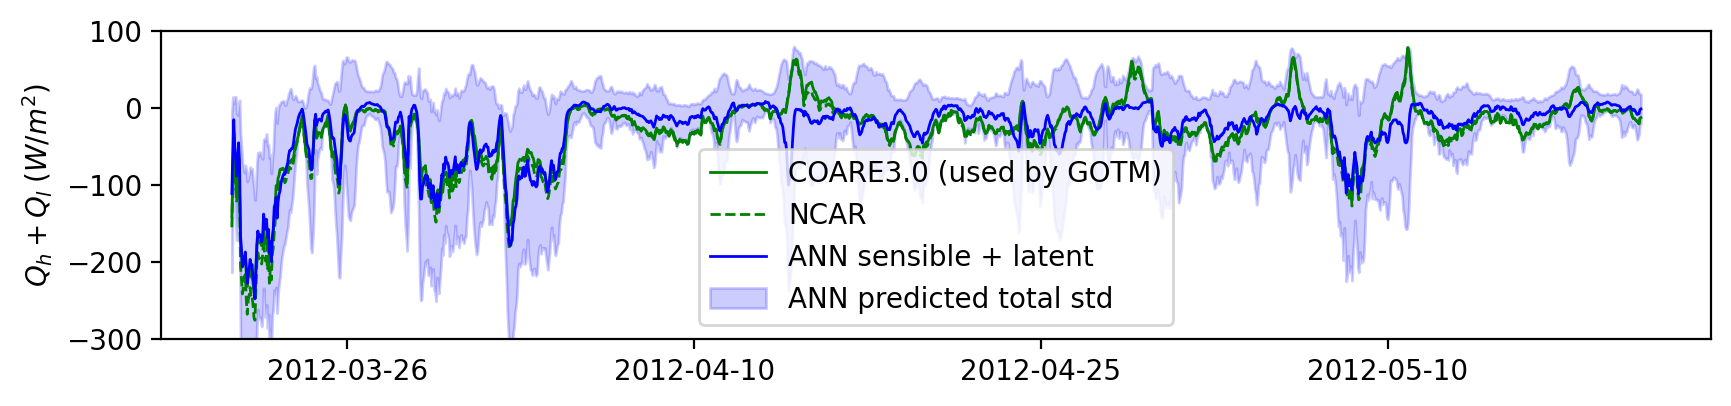

In [32]:
''' Heat flux '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

sd = '2012-03-21'; ed = '2012-05-20'
# sd = '2012-05-21'; ed = '2012-08-20'

# Coarsening to 3-hourly
# ds_hat = ds.resample(datetime='3H').mean() 
# ds_ = ds_hat.sel(datetime=slice(sd,ed))

# Keep 3-hourly
ds_ = ds.sel(datetime=slice(sd,ed))

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds_.datetime, ds_.Q - ds_.lwr, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from NCAR
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds_.sst.to_numpy()+273.15, t_zt=ds_.t.to_numpy()+273.15, 
       hum_zt=ds_.q.to_numpy(), u_zu=ds_.ux.to_numpy(), 
       v_zu=ds_.uy.to_numpy(), slp=ds_.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
plt.plot(ds_.datetime, qh + ql, '--', label='NCAR', c='g', lw=1)

# computed from ANNs
interval = (ds_.qh_ann_sigma + ds_.ql_ann_sigma)**0.5
mean = ds_.qh_ann + ds_.ql_ann 
plt.plot(ds_.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds_.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.ylim([-300, 100]); plt.ylabel('$Q_h+Q_l \; (W/m^2)$')

Text(0, 0.5, '$Q_h+Q_l \\; (W/m^2)$')

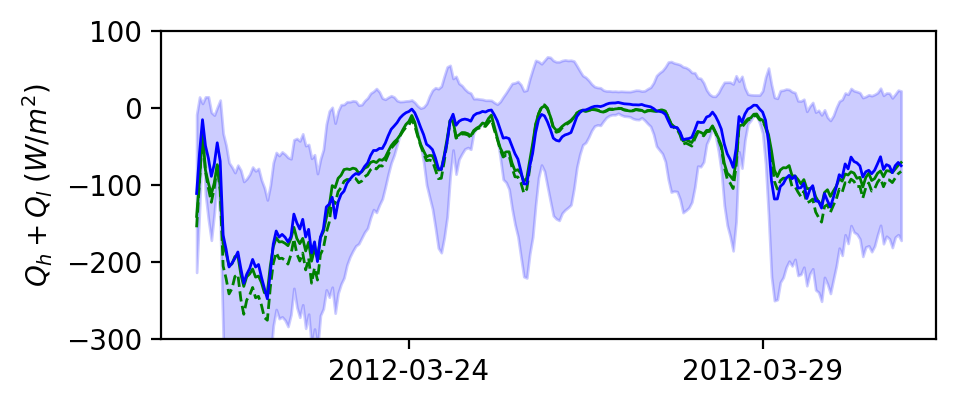

In [39]:
''' Heat flux '''
fig = plt.figure(figsize=[5,2], dpi=200); ax = plt.gca()

sd = '2012-03-21'; ed = '2012-05-20'
sd = '2012-05-21'; ed = '2012-08-20'
# sd = '2012-05-21'; ed = '2012-08-20'

# Coarsening to 3-hourly
# ds_hat = ds.resample(datetime='3H').mean() 
# ds_ = ds_hat.sel(datetime=slice(sd,ed))

# Keep 3-hourly
ds_ = ds.sel(datetime=slice(sd,ed))

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds_.datetime, ds_.Q - ds_.lwr, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from NCAR
ql, qh, taux, tauy, evap = \
noskin_np(sst=ds_.sst.to_numpy()+273.15, t_zt=ds_.t.to_numpy()+273.15, 
       hum_zt=ds_.q.to_numpy(), u_zu=ds_.ux.to_numpy(), 
       v_zu=ds_.uy.to_numpy(), slp=ds_.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
plt.plot(ds_.datetime, qh + ql, '--', label='NCAR', c='g', lw=1)

# computed from ANNs
interval = (ds_.qh_ann_sigma + ds_.ql_ann_sigma)**0.5
mean = ds_.qh_ann + ds_.ql_ann 
plt.plot(ds_.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds_.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.ylim([-300, 100]); plt.ylabel('$Q_h+Q_l \; (W/m^2)$')
plt.legend()

(-300.0, 100.0)

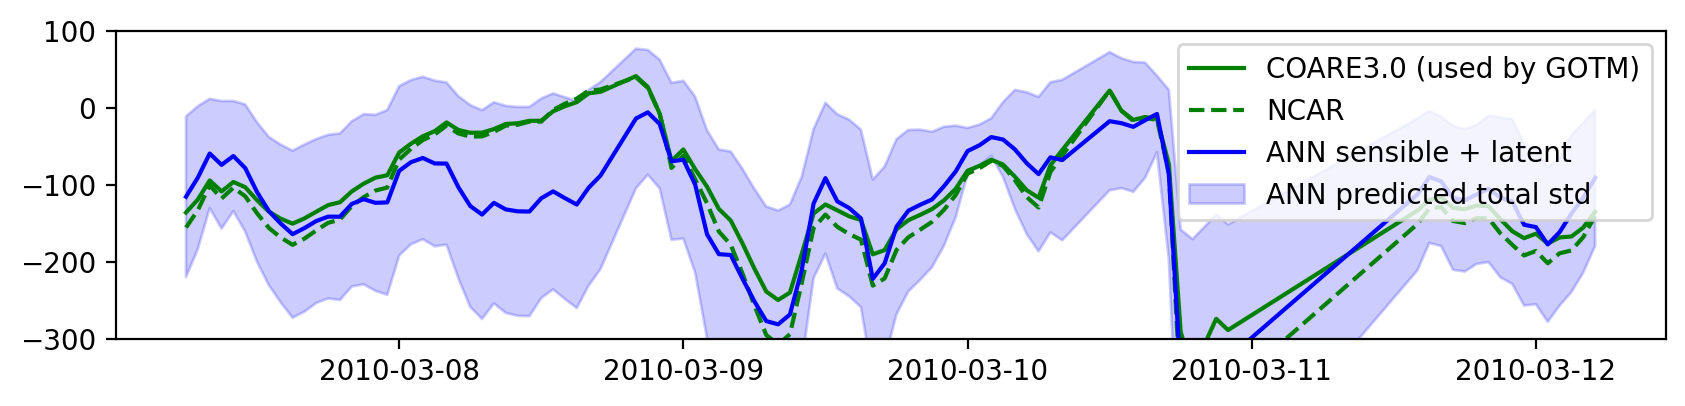

In [92]:
''' Heat flux (from selected best network) '''
fig = plt.figure(figsize=[10,2],dpi=200)

L=1000; R=1100

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(df.datetime[L:R],df.qh[L:R]-df.lwr[L:R],label='COARE3.0 (used by GOTM)',c='g') 

# computed from NCAR
ql, qh, taux, tauy, evap = \
noskin_np(sst=df.sst.to_numpy()+273.15, t_zt=df.t.to_numpy()+273.15, 
       hum_zt=df.q.to_numpy(), u_zu=df.ux.to_numpy(), 
       v_zu=df.uy.to_numpy(), slp=df.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
plt.plot(df.datetime[L:R],qh[L:R]+ql[L:R],'--',label='NCAR',c='g')

# computed from ANN (individual not ensemble)
model_dir = '/home/jw8736/mlflux/saved_model/'
input_keys = ['U','sst','t','rh']
X = torch.tensor(np.hstack([df[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))

model_name = model_dir + 'full_anns_diff_sensible_3layers_split'
filename = model_name + "%g.p" %3
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)
    qh = model.pred_mean(X).detach().numpy().squeeze()
    qh_Sigma = model.pred_var(X).detach().numpy().squeeze()
    
model_name = model_dir + 'full_anns_diff_latent_3layers_split'
filename = model_name + "%g.p" %2
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)
    ql = model.pred_mean(X).detach().numpy().squeeze()
    ql_Sigma = model.pred_var(X).detach().numpy().squeeze()

plt.plot(df.datetime[L:R], qh[L:R]+ql[L:R], label='ANN sensible + latent', color='blue')

plt.fill_between(df.datetime[L:R], (qh[L:R]+ql[L:R])-(qh_Sigma[L:R]+ql_Sigma[L:R])**0.5, 
                 (qh[L:R]+ql[L:R])+(qh_Sigma[L:R]+ql_Sigma[L:R])**0.5, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

plt.legend()
plt.ylim([-300, 100])

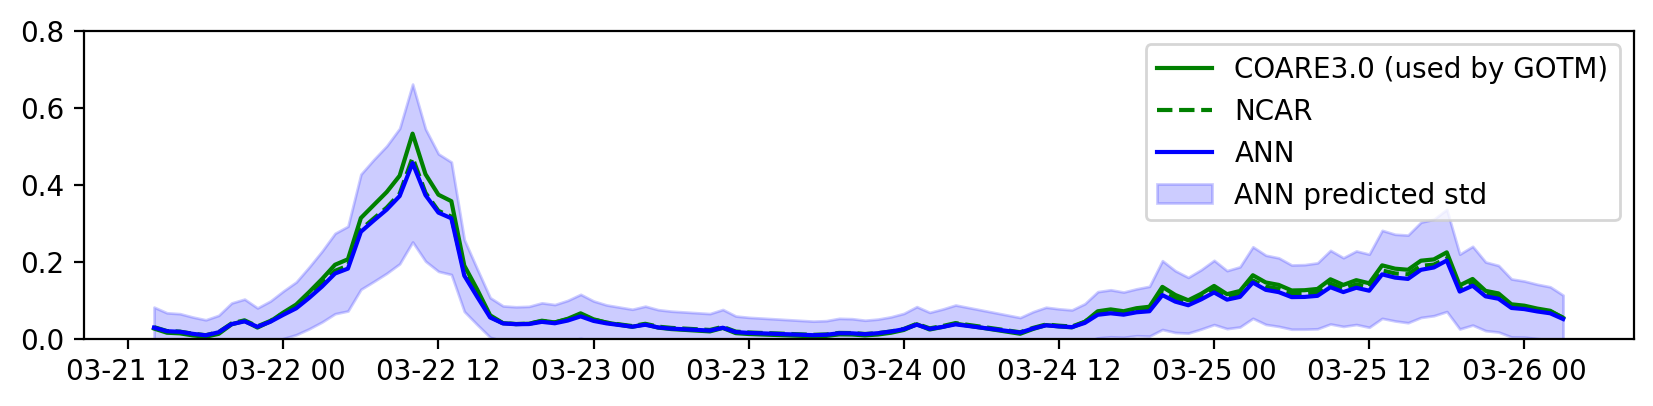

In [106]:
''' Momentum flux '''
fig = plt.figure(figsize=[10,2],dpi=200)

L=26000; R=26100

plt.plot(df.datetime[L:R],(df.taux[L:R]**2+df.tauy[L:R]**2)**0.5, c='g', label='COARE3.0 (used by GOTM)')

ql, qh, taux, tauy, evap = \
noskin_np(sst=df.sst.to_numpy()+273.15, t_zt=df.t.to_numpy()+273.15, 
       hum_zt=df.q.to_numpy(), u_zu=df.ux.to_numpy(), 
       v_zu=df.uy.to_numpy(), slp=df.p.to_numpy(), 
       algo='ncar', zt=2., zu=10.,
       niter=6, input_range_check=True)
plt.plot(df.datetime[L:R],(taux[L:R]**2+tauy[L:R]**2)**0.5, '--', c='g', label='NCAR')

plt.plot(df.datetime[L:R], tau_mean[L:R], label='ANN', color='blue')

plt.fill_between(df.datetime[L:R], tau_mean[L:R]-tau_Sigma_mean[L:R]**0.5, 
                 tau_mean[L:R]+tau_Sigma_mean[L:R]**0.5, 
                 color='blue', alpha=0.2, label='ANN predicted std')
plt.ylim([0,0.8])
plt.legend()

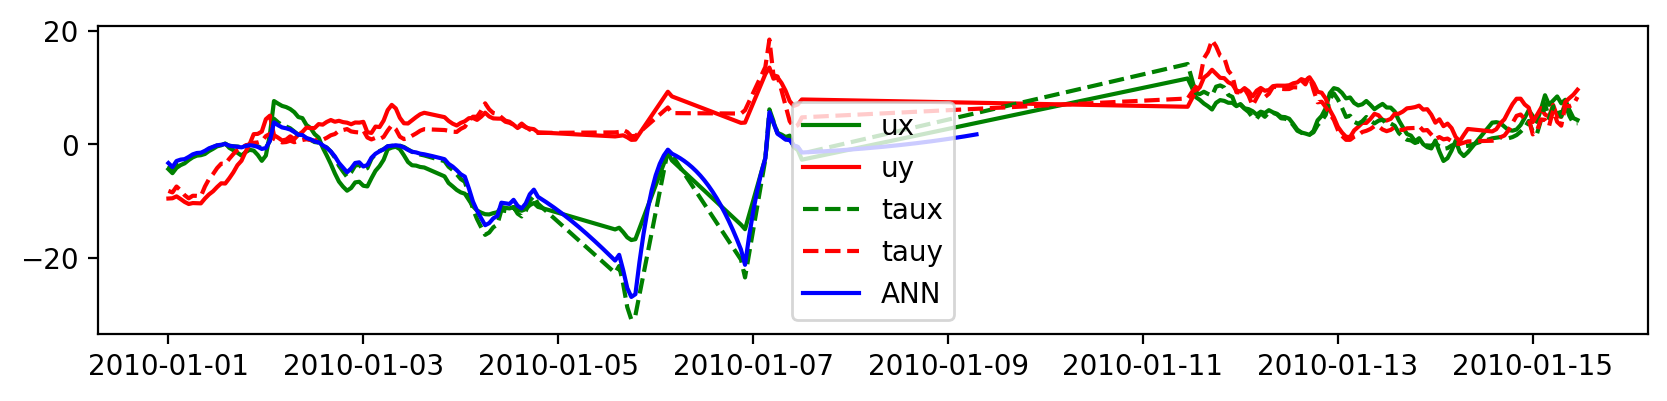

In [29]:
''' Momentum flux components '''
fig = plt.figure(figsize=[10,2],dpi=200)

L=0; R=200

plt.plot(df.datetime[L:R],df.ux[L:R], c='g', label='ux')
plt.plot(df.datetime[L:R],df.uy[L:R], c='r', label='uy')
plt.plot(df.datetime[L:R],df.taux[L:R]*50, '--', c='g', label='taux')
plt.plot(df.datetime[L:R],df.tauy[L:R]*50, '--', c='r', label='tauy')
plt.plot(df_.index[L:R], tau_mean[L:R]*df_.cos[L:R]*50, label='ANN', color='blue')

plt.legend()

(-300.0, 100.0)

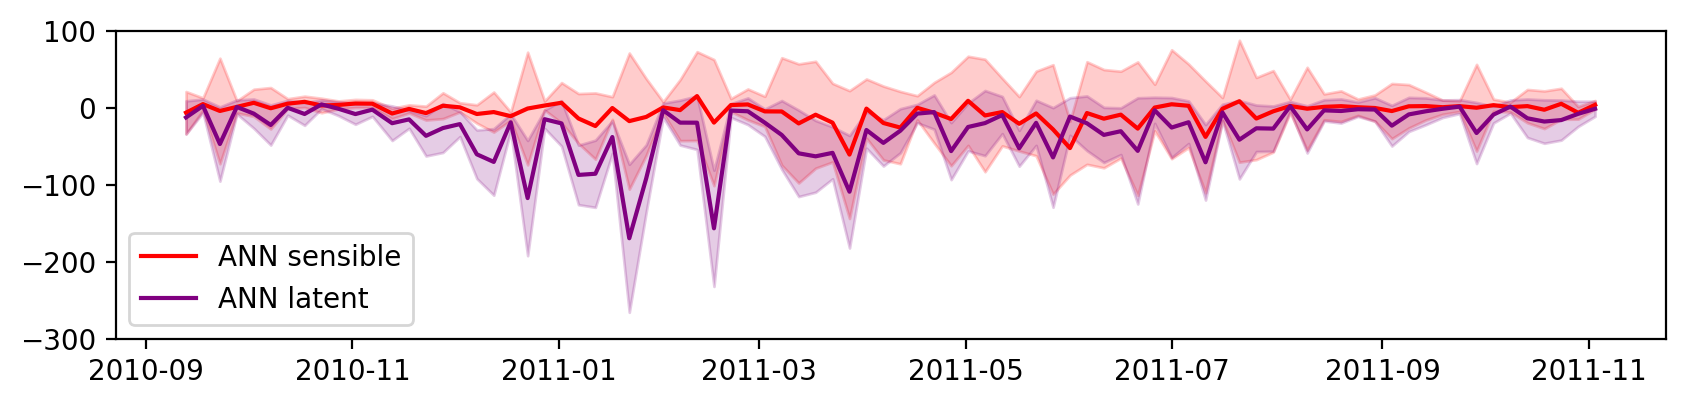

In [142]:
''' Relative importance of sensible and latent components. One year. '''
fig = plt.figure(figsize=[10,2],dpi=200)

L = 4000; R = 14000
i = 24*5

plt.plot(df_.index[L:R:i], qh_mean[L:R:i], label='ANN sensible', color='red')
plt.fill_between(df_.index[L:R:i], (qh_mean[L:R:i])-(qh_Sigma_mean[L:R:i])**0.5, 
                 (qh_mean[L:R:i])+(qh_Sigma_mean[L:R:i])**0.5, 
                 color='red', alpha=0.2)

plt.plot(df_.index[L:R:i], ql_mean[L:R:i], label='ANN latent', color='purple')
plt.fill_between(df_.index[L:R:i], (ql_mean[L:R:i])-(ql_Sigma_mean[L:R:i])**0.5, 
                 (ql_mean[L:R:i])+(ql_Sigma_mean[L:R:i])**0.5, 
                 color='purple', alpha=0.2)

plt.legend()
plt.ylim([-300, 100])

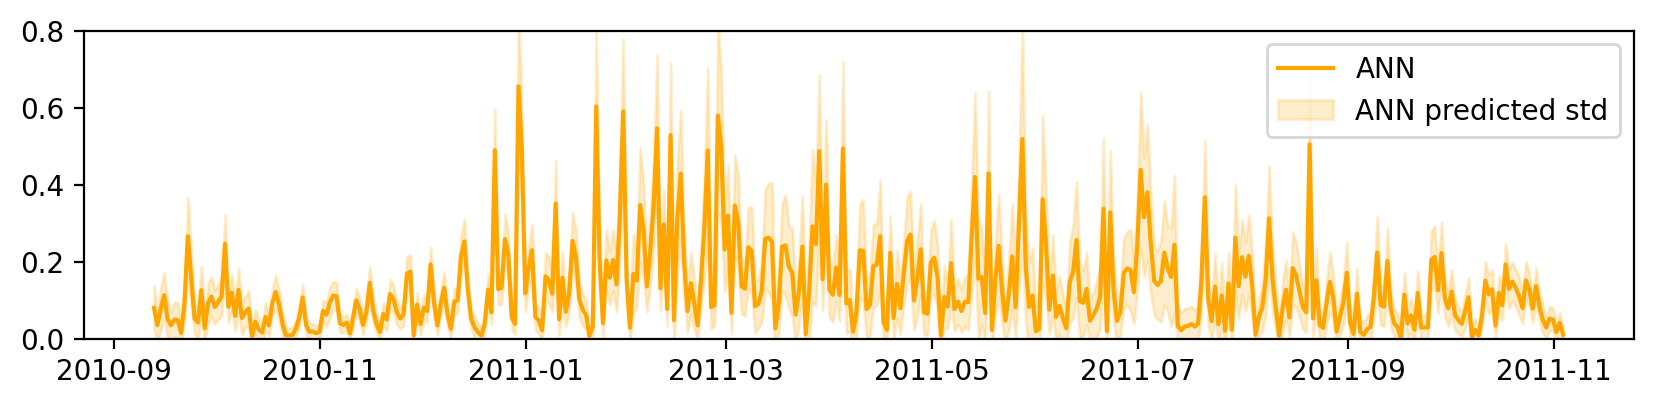

In [143]:
''' Momentum flux (hourly interpolated) '''
fig = plt.figure(figsize=[10,2],dpi=200)

L = 4000; R = 14000
i = 24 # smooth to daily - 5 days - monthly

plt.plot(df_.index[L:R:i], tau_mean[L:R:i], label='ANN', color='orange')

plt.fill_between(df_.index[L:R:i], tau_mean[L:R:i]-tau_Sigma_mean[L:R:i]**0.5, 
                 tau_mean[L:R:i]+tau_Sigma_mean[L:R:i]**0.5, 
                 color='orange', alpha=0.2, label='ANN predicted std')
plt.ylim([0,0.8])
plt.legend()

#### Format and output to flux data files
TODO: merge this part with fluxop.ipynb

In [44]:
path = '/home/jw8736/test-gotm/2012/'

output_file = path + 'heat_flux_3hourly_ann.dat'
# Write the datetime and values to the file, row by row
with open(output_file, 'w') as file:
    for t, val in zip(ds_hat.t.values, ds_hat.Q.values):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val:.8f}\n")

output_file = path + 'momentum_flux_3hourly_ann.dat'
with open(output_file, 'w') as file:
    for t, val1, val2 in zip(ds_hat.t.values, ds_hat.taux.values, ds_hat.tauy.values,):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val1:.8f}\t{val2:.8f}\n")

#### Correlation time scale (bulk and ANN)

points after linear interp: 87450
e-folding time steps: 18, correlation time T: 18.5046 hrs
correlation time from lag-1 T: 32.0253 hrs


(0.0, 200.0)

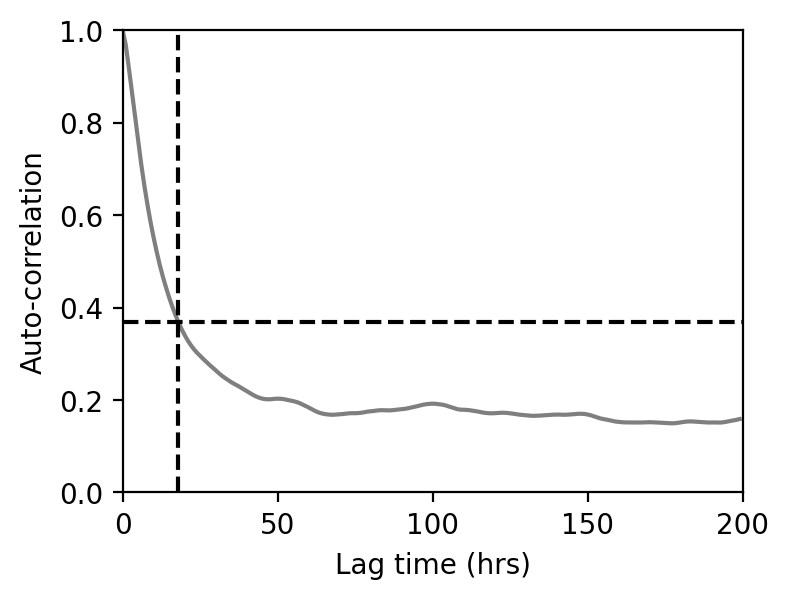

In [114]:
''' Bulk (change variables between heat and momentum) '''
fig = plt.figure(figsize=[4,3], dpi=200)
dur = 80000

for i in (0,):  
    # interpolate onto uniform series
    # buoyancy
    # signal = df.qh[i:(i+dur)] - df.lwr[i:(i+dur)]
    # momentum
    signal = (df_.taux**2+df_.tauy**2)**0.5; signal = signal[i:(i+dur)] # df_ is df with index reset

    signal_interp = signal.resample('h').interpolate(method='linear')
    print('points after linear interp: %g' %len(signal_interp))
    
    # compute correlation
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    plt.plot(corr, c='k', alpha=0.5)
    
    # fit a correlation time
    k = np.argmin(abs(corr-np.exp(-1)))
    plt.axvline(x=k, color='k', ls='--')
    T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
    print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
    # a different way to fit correlation time
    T = 1/(1 - corr[1])
    print('correlation time from lag-1 T: %g hrs' %(T))
    
plt.axhline(y=np.exp(-1.), color='k', ls='--')

plt.ylabel('Auto-correlation'); plt.ylim([0,1])
plt.xlabel('Lag time (hrs)'); plt.xlim([0,200])

e-folding time steps: 19, correlation time T: 19.5044 hrs
correlation time from lag-1 T: 37.266 hrs


(0.0, 200.0)

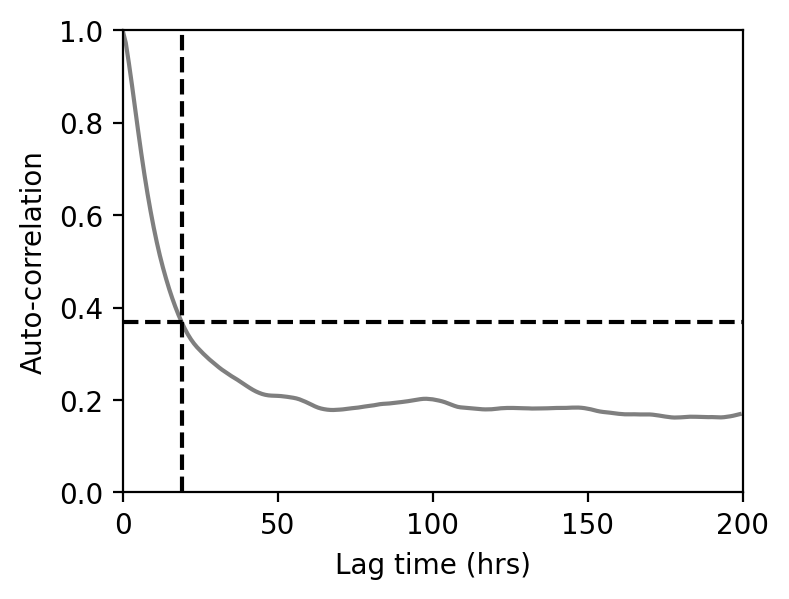

In [133]:
''' ANN (already resampled to hourly when computing flux outputs so no need to interpolate again. '''
fig = plt.figure(figsize=[4,3], dpi=200)
dur = 90000
df_ = df.set_index('datetime')

for i in (0,):  
    # interpolate onto uniform series
    # buoyancy
    # signal_interp = qh_mean + ql_mean
    # momentum
    signal_interp = tau_mean; signal_interp = signal_interp[i:(i+dur)]
    
    # compute correlation
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    plt.plot(corr, c='k', alpha=0.5)
    
    # fit a correlation time
    k = np.argmin(abs(corr-np.exp(-1)))
    plt.axvline(x=k, color='k', ls='--')
    T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
    print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
    # a different way to fit correlation time
    T = 1/(1 - corr[1])
    print('correlation time from lag-1 T: %g hrs' %(T))
    
plt.axhline(y=np.exp(-1.), color='k', ls='--')

plt.ylabel('Auto-correlation'); plt.ylim([0,1])
plt.xlabel('Lag time (hrs)'); plt.xlim([0,200])

#### Statistics

In [9]:
taub = (ds.taux**2+ds.tauy**2)**0.5
tauann = (ds.taux_ann**2+ds.tauy_ann**2)**0.5
R2 = 1 - np.mean((tauann-taub)**2)/np.var(taub)
print('Momentum flux R2: %.4f' %R2)

R2 = 1 - np.mean((ds.Q - ds.Q_ann)**2)/np.var(ds.Q)
print('Turbulent heat flux R2: %.4f' %R2)

Momentum flux R2: 0.9483
Turbulent heat flux R2: 0.8717


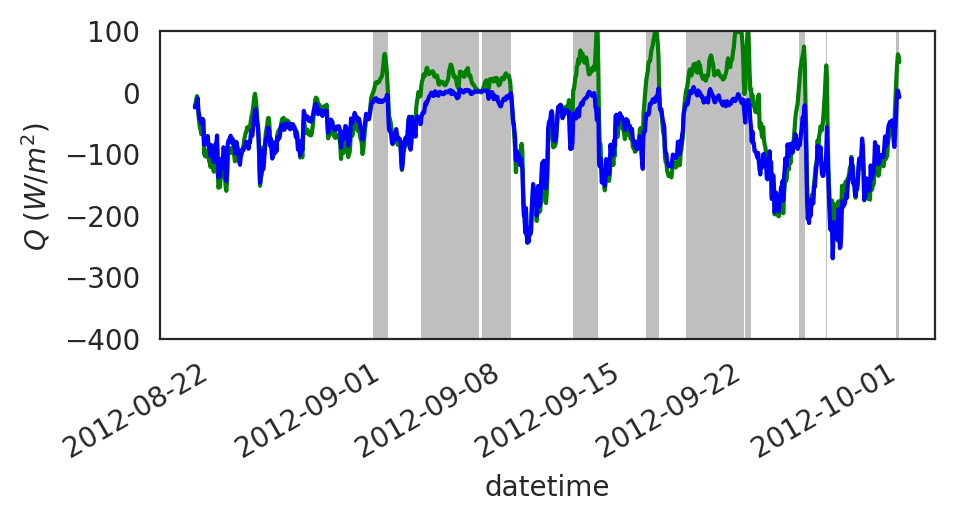

In [44]:
fig = plt.figure(figsize=[5,2], dpi=200); ax = plt.gca()

sd = '2012-03-21'; ed = '2012-05-20'
sd = '2012-05-21'; ed = '2012-08-20'
sd = '2012-08-21'; ed = '2013-01-10'
sd = '2012-08-21'; ed = '2012-09-30'

# Coarsening to 3-hourly
# ds_hat = ds.resample(datetime='3H').mean() 
# ds_ = ds_hat.sel(datetime=slice(sd,ed))

# Keep 3-hourly
ds_ = ds.sel(datetime=slice(sd,ed))

ds_far = ds_.where(abs(ds_.Q-ds_.Q_ann)/(ds_.Q+0.0000001) > 0.2)
ds_.Q.plot(label='Bulk', c='g')
ds_.Q_ann.plot(label='ANN', c='b')
cond = abs(ds_.Q-ds_.Q_ann)/(ds_.Q+0.0000001) > 0.2
plt.ylim([-400,100]); plt.ylabel('$Q\; (W/m^2)$ ')
plt.fill_between(ds_.datetime, -400, 100, where=cond, color='gray', alpha=0.5, edgecolor='None')

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


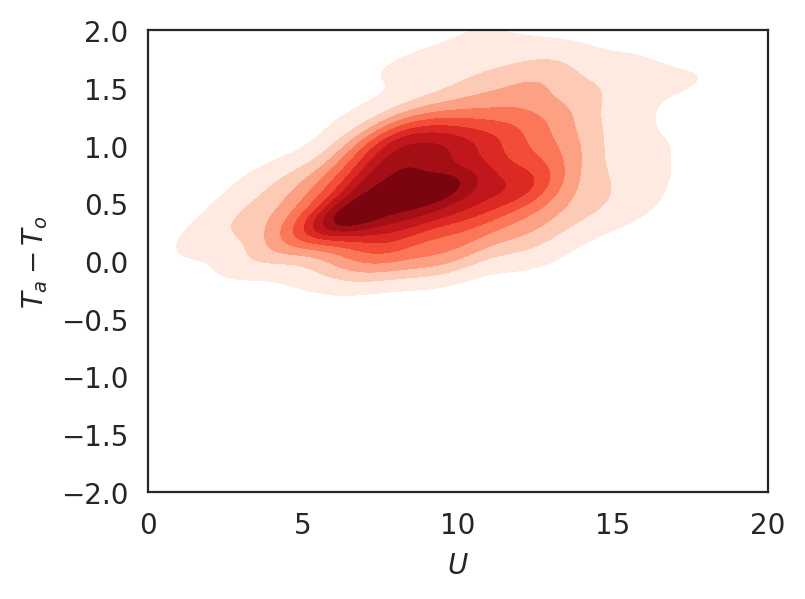

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=[4,3], dpi=200); ax = plt.gca()

sd = '2012-08-21'; ed = '2013-08-20'
ds_ = ds.sel(datetime=slice(sd,ed))
ds_far = ds_.where(abs(ds_.Q-ds_.Q_ann)/(ds_.Q+0.0000001) > 0.2)

# sns.set_style("white")
sns.kdeplot(x=ds_far.U, y=ds_far.t-ds_far.sst, cmap="Reds", fill=True, ax=ax)
ax.set_xlabel('$U$'); ax.set_ylabel('$T_a-T_o$')
ax.set_xlim([0,20]); ax.set_ylim([-2,2]); plt.show()

/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


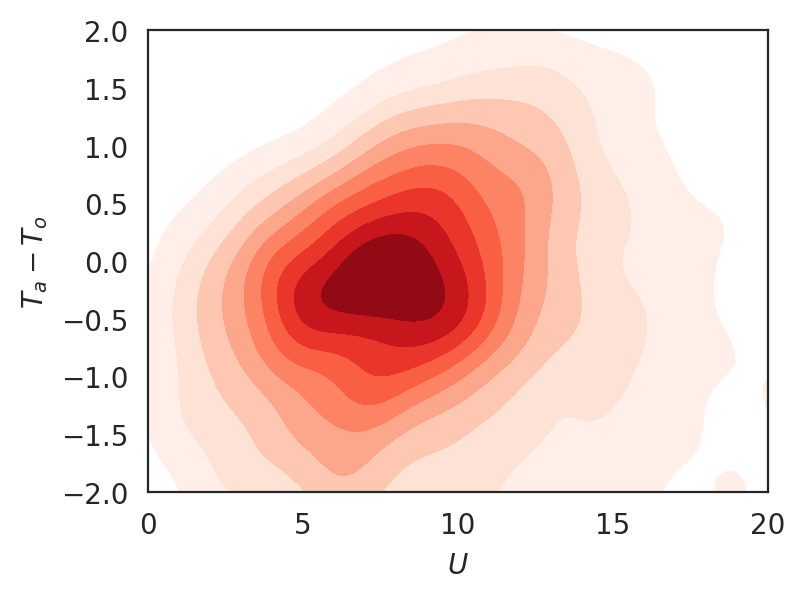

In [48]:
fig = plt.figure(figsize=[4,3], dpi=200); ax = plt.gca()
sd = '2012-08-21'; ed = '2013-08-20'
ds_ = ds.sel(datetime=slice(sd,ed))
# sns.set_style("white")
sns.kdeplot(x=ds_.U, y=ds_.t-ds_.sst, cmap="Reds", fill=True, ax=ax)
ax.set_xlabel('$U$'); ax.set_ylabel('$T_a-T_o$')
ax.set_xlim([0,20]); ax.set_ylim([-2,2]); plt.show()

In [16]:
''' Initial condition and results: temperature and salinity profiles. Post 2010. '''
file_tprof = {'filename':'tprof_papa_hourly.dat'}
file_sprof = {'filename':'sprof_papa_hourly.dat'}

In [ ]:
''' Year 1959 - 1981 '''
file_qh = {'filename':'heatflux.dat', 'columns':['qh']}
# momentumflux.dat
# tprof.dat

### Read in profiles from provided format

In [145]:
file_path = path + 'tprof_papa_hourly' # not uniform (upper 300m) verqtical layers, hourly
file_path = path + 'tprof_woa.dat' # uniform vertical fqull depth but monthly
file_path = path + 'tprof.dat' # uniform vertical (upper 300m), roughly 6 hourly

N = 61  # Skip every 16 lines

var2D = []
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        # Skip every Nth line
        if i % N == 0:
            # print(line.strip())
            # TODO: extract time and vertical points
            
            zz = []
            varz = []
            if i // N > 0:
                var2D.append(varz)
            continue
        else:
            z, var = line.strip().split()
            zz.append(float(z))
            varz.append(float(var))

            # TODO: perform interpolation onto a uniform grid
            

In [ ]:
########### C function ################
# void init_profile (Point point, const char * fname,
# 		   int sy, int sm, int sd, scalar s)
# {
#   FILE * fp = fopen (fname, "r");
#   if (!fp) {
#     perror (fname);
#     exit (1);
#   }
#   int yy, m, d, n;
#   do {
#     if (fscanf (fp, "%d/%d/%d %*s %d %*d", &yy, &m, &d, &n) != 4) {
#       fprintf (stderr, "%s: error: cannot read date\n", fname);
#       exit (1);
#     }
#     if (yy < sy || (yy == sy && m < sm) || (yy == sy && m == sm && d < sd))
#       for (int i = 0; i < n; i++)
# 	      fscanf (fp, "%*f %*f");
#     else
#       break;
#   } while (1);
#   double zd[n], od[n];
#   int i = 0;
#   while (fscanf (fp, "%lf %lf", &zd[i], &od[i]) == 2)
#     i++;
#   if (i != n) {
#     fprintf (stderr, "%s: error: not enough points: read %d out of %d\n",
# 	     fname, i, n);
#     exit (1);
#   }
#   double zc = zb[];
#   foreach_layer() {
#     zc += h[]/2.;
#     int i;
#     for (i = 1; i < n && zd[i] >= zc; i++);
#     if (i < n)
#       s[] = (od[i-1]*(zd[i] - zc) + od[i]*(zc - zd[i-1]))/(zd[i] - zd[i-1]);
#     else
#       s[] = od[i-1];
#     zc += h[]/2.;
#   }
#   fclose (fp);
# }

### Read in GOTM outputs

In [19]:
from io import StringIO
import numpy as np
import xarray as xr

def make_ds(filename):
    ''' Read in output and turn into 2D field. '''
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    # Exclude the last two lines
    lines_to_keep = lines[:-2]
    # Join valid lines into a single string with newline characters
    valid_data = "\n".join(lines_to_keep)
    df = pd.read_csv(StringIO(valid_data), sep='\s+', header=None, names=['t','z','ux','uy','T','S','nn','nu'])
    
    # By default, reshape uses row-major (C-style) order, meaning it fills the array row by row.
    n1 = 731 # number of time steps
    n2 = 250 # number of depth
    time = df['t'][::n2]/3600. # output is every 12 hrs (from second to hour)
    depth = df['z'][:n2] # depth are 1 m apart

    ux_2D = np.reshape(df['ux'],(n1,n2))
    uy_2D = np.reshape(df['uy'],(n1,n2))
    T = np.reshape(df['T'],(n1,n2))
    S = np.reshape(df['S'],(n1,n2))

    xrdf = xr.Dataset(
        {'ux': (['t','z'], ux_2D),
        'uy': (['t','z'], uy_2D),
        'T': (['t','z'], T),
        'S': (['t','z'], S)},
        coords={
            "t": time,
            "z": depth
        },)
    
    return xrdf